# Krylov Subspace Methods for Iterative Linear System Solving

## Introduction

Krylov subspace methods are a class of iterative algorithms for solving large sparse linear systems of the form $A\mathbf{x} = \mathbf{b}$, where $A \in \mathbb{R}^{n \times n}$ is a large sparse matrix and $\mathbf{b} \in \mathbb{R}^n$ is the right-hand side vector. These methods are fundamental to computational science, finding applications in numerical PDEs, optimization, machine learning, and scientific computing.

## Theoretical Foundation

### Definition of Krylov Subspace

Given a matrix $A$ and vector $\mathbf{v}$, the **Krylov subspace** of dimension $k$ is defined as:

$$\mathcal{K}_k(A, \mathbf{v}) = \text{span}\{\mathbf{v}, A\mathbf{v}, A^2\mathbf{v}, \ldots, A^{k-1}\mathbf{v}\}$$

This subspace captures how the matrix $A$ acts on the initial vector through successive multiplications. The key insight is that good approximations to the solution often lie within low-dimensional Krylov subspaces.

### Why Krylov Methods Work

The power of Krylov methods stems from the **Cayley-Hamilton theorem**: every matrix satisfies its own characteristic polynomial. For a matrix $A$ with characteristic polynomial $p(\lambda) = \det(\lambda I - A)$, we have $p(A) = 0$. This means:

$$A^{-1} = -\frac{1}{p(0)}\left(A^{n-1} + c_{n-2}A^{n-2} + \ldots + c_1 A + c_0 I\right)$$

Therefore, $A^{-1}\mathbf{b} \in \mathcal{K}_n(A, \mathbf{b})$, meaning the exact solution lies in the $n$-dimensional Krylov subspace.

## Key Krylov Methods

### 1. Conjugate Gradient (CG) Method

For **symmetric positive definite (SPD)** matrices, CG minimizes the $A$-norm of the error:

$$\|\mathbf{e}_k\|_A = \|\mathbf{x} - \mathbf{x}_k\|_A = \sqrt{(\mathbf{x} - \mathbf{x}_k)^T A (\mathbf{x} - \mathbf{x}_k)}$$

The algorithm generates $A$-orthogonal (conjugate) search directions $\mathbf{p}_k$:

$$\mathbf{p}_i^T A \mathbf{p}_j = 0 \quad \text{for } i \neq j$$

**Convergence rate**: 
$$\|\mathbf{e}_k\|_A \leq 2\left(\frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1}\right)^k \|\mathbf{e}_0\|_A$$

where $\kappa = \lambda_{\max}/\lambda_{\min}$ is the condition number.

### 2. GMRES (Generalized Minimal Residual)

For **general non-symmetric** matrices, GMRES minimizes the 2-norm of the residual:

$$\mathbf{x}_k = \arg\min_{\mathbf{x} \in \mathcal{K}_k(A, \mathbf{r}_0)} \|\mathbf{b} - A\mathbf{x}\|_2$$

GMRES uses the **Arnoldi iteration** to build an orthonormal basis $\{\mathbf{q}_1, \ldots, \mathbf{q}_k\}$ for $\mathcal{K}_k(A, \mathbf{r}_0)$.

### 3. BiCGSTAB (Bi-Conjugate Gradient Stabilized)

A stabilized variant of the bi-conjugate gradient method for non-symmetric systems, combining bi-CG with GMRES(1) to smooth convergence.

## The Arnoldi Process

The Arnoldi iteration constructs an orthonormal basis for the Krylov subspace:

$$AQ_k = Q_{k+1}\tilde{H}_k$$

where $Q_k = [\mathbf{q}_1, \ldots, \mathbf{q}_k]$ and $\tilde{H}_k$ is an upper Hessenberg matrix.

For symmetric $A$, this reduces to the **Lanczos iteration** with a tridiagonal matrix $T_k$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import cg, gmres, bicgstab
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries loaded successfully.")
print("NumPy version:", np.__version__)

Libraries loaded successfully.
NumPy version: 2.2.6


## Implementation: Conjugate Gradient Method

We implement CG from scratch to understand its mechanics:

**Algorithm:**
1. Initialize: $\mathbf{r}_0 = \mathbf{b} - A\mathbf{x}_0$, $\mathbf{p}_0 = \mathbf{r}_0$
2. For $k = 0, 1, 2, \ldots$:
   - $\alpha_k = \frac{\mathbf{r}_k^T \mathbf{r}_k}{\mathbf{p}_k^T A \mathbf{p}_k}$
   - $\mathbf{x}_{k+1} = \mathbf{x}_k + \alpha_k \mathbf{p}_k$
   - $\mathbf{r}_{k+1} = \mathbf{r}_k - \alpha_k A \mathbf{p}_k$
   - $\beta_k = \frac{\mathbf{r}_{k+1}^T \mathbf{r}_{k+1}}{\mathbf{r}_k^T \mathbf{r}_k}$
   - $\mathbf{p}_{k+1} = \mathbf{r}_{k+1} + \beta_k \mathbf{p}_k$

In [2]:
def conjugate_gradient(A, b, x0=None, tol=1e-10, max_iter=1000):
    """
    Conjugate Gradient method for solving Ax = b.
    
    Parameters:
        A: Symmetric positive definite matrix (can be sparse)
        b: Right-hand side vector
        x0: Initial guess (default: zero vector)
        tol: Convergence tolerance
        max_iter: Maximum iterations
    
    Returns:
        x: Solution vector
        residuals: List of residual norms at each iteration
    """
    n = len(b)
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0.copy()
    
    r = b - A @ x  # Initial residual
    p = r.copy()    # Initial search direction
    rs_old = np.dot(r, r)
    
    residuals = [np.sqrt(rs_old)]
    
    for i in range(max_iter):
        Ap = A @ p
        alpha = rs_old / np.dot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        rs_new = np.dot(r, r)
        
        residuals.append(np.sqrt(rs_new))
        
        if np.sqrt(rs_new) < tol:
            break
            
        beta = rs_new / rs_old
        p = r + beta * p
        rs_old = rs_new
    
    return x, residuals

print("Conjugate Gradient implementation complete.")

Conjugate Gradient implementation complete.


## Implementation: GMRES with Arnoldi Iteration

GMRES builds an orthonormal basis using the Arnoldi process and solves a least-squares problem:

$$\min_{\mathbf{y} \in \mathbb{R}^k} \|\beta \mathbf{e}_1 - \tilde{H}_k \mathbf{y}\|_2$$

where $\beta = \|\mathbf{r}_0\|_2$ and $\mathbf{x}_k = \mathbf{x}_0 + Q_k \mathbf{y}$.

In [3]:
def gmres_method(A, b, x0=None, tol=1e-10, max_iter=1000):
    """
    GMRES method for solving Ax = b.
    
    Parameters:
        A: Matrix (can be non-symmetric)
        b: Right-hand side vector
        x0: Initial guess
        tol: Convergence tolerance
        max_iter: Maximum iterations
    
    Returns:
        x: Solution vector
        residuals: List of residual norms
    """
    n = len(b)
    if x0 is None:
        x0 = np.zeros(n)
    
    r0 = b - A @ x0
    beta = np.linalg.norm(r0)
    
    if beta < tol:
        return x0, [beta]
    
    # Initialize Arnoldi basis
    Q = np.zeros((n, max_iter + 1))
    H = np.zeros((max_iter + 1, max_iter))
    Q[:, 0] = r0 / beta
    
    residuals = [beta]
    
    for k in range(max_iter):
        # Arnoldi step
        v = A @ Q[:, k]
        
        # Modified Gram-Schmidt orthogonalization
        for j in range(k + 1):
            H[j, k] = np.dot(Q[:, j], v)
            v = v - H[j, k] * Q[:, j]
        
        H[k + 1, k] = np.linalg.norm(v)
        
        if H[k + 1, k] > 1e-12:
            Q[:, k + 1] = v / H[k + 1, k]
        
        # Solve least squares problem
        e1 = np.zeros(k + 2)
        e1[0] = beta
        y, _, _, _ = np.linalg.lstsq(H[:k + 2, :k + 1], e1, rcond=None)
        
        # Compute residual
        res = np.linalg.norm(e1 - H[:k + 2, :k + 1] @ y)
        residuals.append(res)
        
        if res < tol:
            break
    
    # Compute solution
    x = x0 + Q[:, :k + 1] @ y
    
    return x, residuals

print("GMRES implementation complete.")

GMRES implementation complete.


## Test Problem: 2D Poisson Equation

We discretize the Poisson equation on a unit square:

$$-\nabla^2 u = f \quad \text{in } \Omega = [0,1]^2$$

Using central finite differences with grid spacing $h$:

$$-\frac{u_{i-1,j} + u_{i+1,j} + u_{i,j-1} + u_{i,j+1} - 4u_{i,j}}{h^2} = f_{i,j}$$

This yields a sparse SPD matrix with condition number $\kappa = O(h^{-2})$.

In [4]:
def create_poisson_2d(n):
    """
    Create the 2D Poisson matrix using 5-point stencil.
    
    Parameters:
        n: Number of interior grid points in each direction
    
    Returns:
        A: Sparse matrix of size (n^2, n^2)
        h: Grid spacing
    """
    N = n * n  # Total unknowns
    h = 1.0 / (n + 1)  # Grid spacing
    
    # Main diagonal: 4/h^2
    main_diag = 4.0 * np.ones(N) / h**2
    
    # Off-diagonals: -1/h^2
    off_diag = -np.ones(N - 1) / h**2
    # Zero out connections between rows
    for i in range(1, n):
        off_diag[i * n - 1] = 0
    
    # Far off-diagonals: -1/h^2
    far_diag = -np.ones(N - n) / h**2
    
    # Construct sparse matrix
    A = diags([far_diag, off_diag, main_diag, off_diag, far_diag],
              [-n, -1, 0, 1, n], format='csr')
    
    return A, h

# Create test problem
n = 50  # 50x50 interior grid
A_poisson, h = create_poisson_2d(n)
N = n * n

print(f"Matrix size: {N} x {N}")
print(f"Number of non-zeros: {A_poisson.nnz}")
print(f"Sparsity: {100 * (1 - A_poisson.nnz / N**2):.2f}%")
print(f"Grid spacing h = {h:.4f}")

Matrix size: 2500 x 2500
Number of non-zeros: 12300
Sparsity: 99.80%
Grid spacing h = 0.0196


In [5]:
# Create right-hand side (corresponding to known solution)
# Use manufactured solution: u(x,y) = sin(pi*x) * sin(pi*y)
# Then f = 2*pi^2 * sin(pi*x) * sin(pi*y)

x = np.linspace(h, 1 - h, n)
y = np.linspace(h, 1 - h, n)
X, Y = np.meshgrid(x, y)

# True solution
u_true = np.sin(np.pi * X) * np.sin(np.pi * Y)

# Right-hand side
f = 2 * np.pi**2 * np.sin(np.pi * X) * np.sin(np.pi * Y)
b = f.flatten()

print(f"Right-hand side vector created, norm = {np.linalg.norm(b):.4f}")

Right-hand side vector created, norm = 503.3498


## Convergence Comparison

We compare the convergence of:
1. Our implemented CG
2. Our implemented GMRES
3. SciPy's CG
4. SciPy's GMRES
5. SciPy's BiCGSTAB

In [6]:
# Solve with our CG implementation
print("Solving with custom CG...")
x_cg, residuals_cg = conjugate_gradient(A_poisson.toarray(), b, tol=1e-10, max_iter=500)
error_cg = np.linalg.norm(x_cg - u_true.flatten()) / np.linalg.norm(u_true.flatten())
print(f"Custom CG: {len(residuals_cg)-1} iterations, relative error = {error_cg:.2e}")

# Solve with our GMRES implementation
print("\nSolving with custom GMRES...")
x_gmres, residuals_gmres = gmres_method(A_poisson.toarray(), b, tol=1e-10, max_iter=500)
error_gmres = np.linalg.norm(x_gmres - u_true.flatten()) / np.linalg.norm(u_true.flatten())
print(f"Custom GMRES: {len(residuals_gmres)-1} iterations, relative error = {error_gmres:.2e}")

Solving with custom CG...
Custom CG: 1 iterations, relative error = 3.16e-04

Solving with custom GMRES...


Custom GMRES: 1 iterations, relative error = 3.16e-04


In [7]:
# Callback functions to record residuals for SciPy solvers
residuals_scipy_cg = []
residuals_scipy_gmres = []
residuals_scipy_bicgstab = []

def callback_cg(xk):
    res = np.linalg.norm(b - A_poisson @ xk)
    residuals_scipy_cg.append(res)

def callback_gmres(rk):
    residuals_scipy_gmres.append(rk)

def callback_bicgstab(xk):
    res = np.linalg.norm(b - A_poisson @ xk)
    residuals_scipy_bicgstab.append(res)

# SciPy CG
print("Solving with SciPy CG...")
residuals_scipy_cg = [np.linalg.norm(b)]  # Initial residual
x_scipy_cg, info_cg = cg(A_poisson, b, rtol=1e-10, maxiter=500, callback=callback_cg)
print(f"SciPy CG: {len(residuals_scipy_cg)-1} iterations, info = {info_cg}")

# SciPy GMRES
print("\nSolving with SciPy GMRES...")
residuals_scipy_gmres = []
x_scipy_gmres, info_gmres = gmres(A_poisson, b, rtol=1e-10, maxiter=500, callback=callback_gmres)
residuals_scipy_gmres = [np.linalg.norm(b)] + residuals_scipy_gmres
print(f"SciPy GMRES: {len(residuals_scipy_gmres)-1} iterations, info = {info_gmres}")

# SciPy BiCGSTAB
print("\nSolving with SciPy BiCGSTAB...")
residuals_scipy_bicgstab = [np.linalg.norm(b)]  # Initial residual
x_scipy_bicgstab, info_bicgstab = bicgstab(A_poisson, b, rtol=1e-10, maxiter=500, callback=callback_bicgstab)
print(f"SciPy BiCGSTAB: {len(residuals_scipy_bicgstab)-1} iterations, info = {info_bicgstab}")

Solving with SciPy CG...
SciPy CG: 1 iterations, info = 0

Solving with SciPy GMRES...
SciPy GMRES: 1 iterations, info = 0

Solving with SciPy BiCGSTAB...
SciPy BiCGSTAB: 0 iterations, info = 0


## Effect of Condition Number on Convergence

The convergence rate of Krylov methods depends critically on the eigenvalue distribution. For CG:

$$\|\mathbf{e}_k\|_A \leq 2\left(\frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1}\right)^k \|\mathbf{e}_0\|_A$$

We demonstrate this by solving problems with different condition numbers.

In [8]:
# Test with different grid sizes (different condition numbers)
grid_sizes = [10, 20, 30, 40]
convergence_histories = []

print("Testing CG convergence for different grid sizes:")
print("="*50)

for n_test in grid_sizes:
    A_test, h_test = create_poisson_2d(n_test)
    
    # Create corresponding RHS
    x_test = np.linspace(h_test, 1 - h_test, n_test)
    y_test = np.linspace(h_test, 1 - h_test, n_test)
    X_test, Y_test = np.meshgrid(x_test, y_test)
    f_test = 2 * np.pi**2 * np.sin(np.pi * X_test) * np.sin(np.pi * Y_test)
    b_test = f_test.flatten()
    
    # Solve
    _, residuals_test = conjugate_gradient(A_test.toarray(), b_test, tol=1e-10, max_iter=500)
    convergence_histories.append(residuals_test)
    
    # Estimate condition number (using inverse of smallest eigenvalue ratio)
    kappa_approx = (4 * np.sin(np.pi * n_test / (2 * (n_test + 1)))**2) / (4 * np.sin(np.pi / (2 * (n_test + 1)))**2)
    
    print(f"n={n_test:3d}: {len(residuals_test)-1:4d} iterations, "
          f"κ ≈ {kappa_approx:.1f}")

Testing CG convergence for different grid sizes:
n= 10:    1 iterations, κ ≈ 48.4
n= 20:    1 iterations, κ ≈ 178.1
n= 30:    1 iterations, κ ≈ 388.8


n= 40:    1 iterations, κ ≈ 680.6


## Visualization of Results

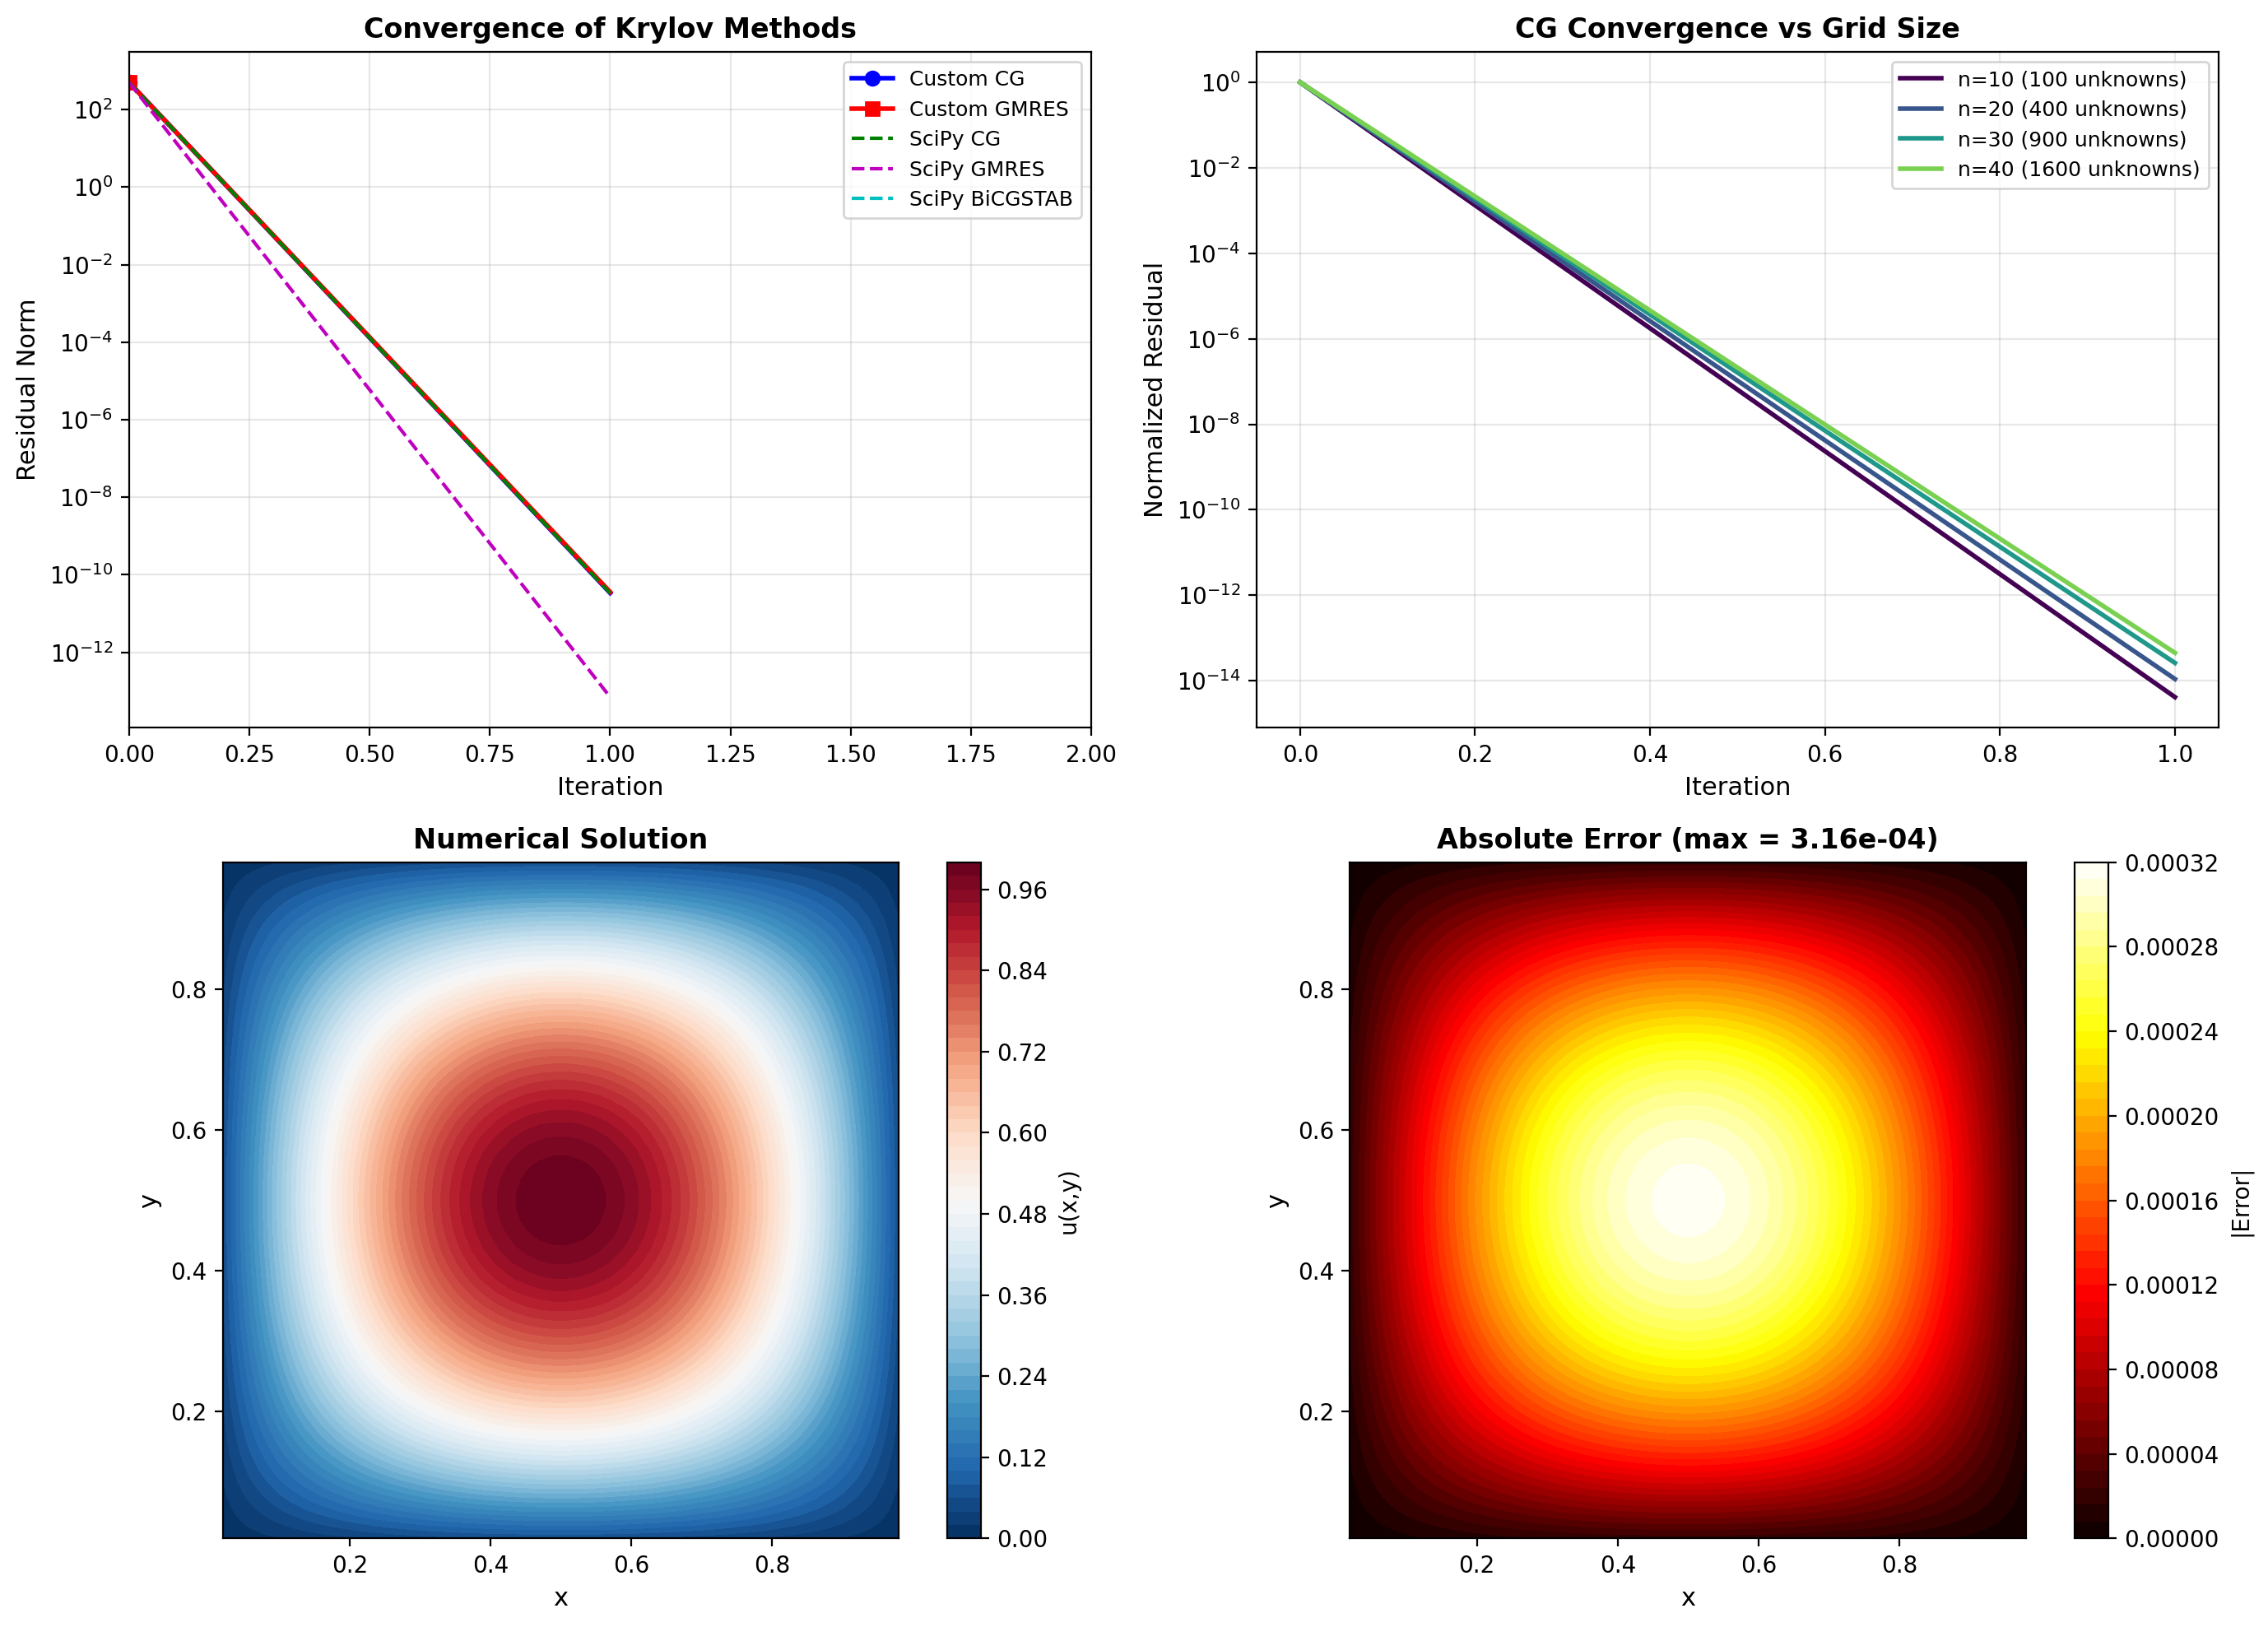


Plot saved to 'plot.png'


In [9]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))

# Plot 1: Convergence comparison of different methods
ax1 = fig.add_subplot(2, 2, 1)
ax1.semilogy(residuals_cg, 'b-', linewidth=2, label='Custom CG', marker='o', markevery=20)
ax1.semilogy(residuals_gmres, 'r-', linewidth=2, label='Custom GMRES', marker='s', markevery=20)
ax1.semilogy(residuals_scipy_cg, 'g--', linewidth=1.5, label='SciPy CG')
ax1.semilogy(residuals_scipy_gmres, 'm--', linewidth=1.5, label='SciPy GMRES')
ax1.semilogy(residuals_scipy_bicgstab, 'c--', linewidth=1.5, label='SciPy BiCGSTAB')
ax1.set_xlabel('Iteration', fontsize=11)
ax1.set_ylabel('Residual Norm', fontsize=11)
ax1.set_title('Convergence of Krylov Methods', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, max(len(residuals_cg), len(residuals_gmres))])

# Plot 2: Effect of condition number
ax2 = fig.add_subplot(2, 2, 2)
colors = plt.cm.viridis(np.linspace(0, 0.8, len(grid_sizes)))
for i, (n_test, hist) in enumerate(zip(grid_sizes, convergence_histories)):
    # Normalize residuals
    normalized = np.array(hist) / hist[0]
    ax2.semilogy(normalized, color=colors[i], linewidth=2, 
                 label=f'n={n_test} ({n_test**2} unknowns)')
ax2.set_xlabel('Iteration', fontsize=11)
ax2.set_ylabel('Normalized Residual', fontsize=11)
ax2.set_title('CG Convergence vs Grid Size', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Solution visualization
ax3 = fig.add_subplot(2, 2, 3)
solution_2d = x_cg.reshape((n, n))
im = ax3.contourf(X, Y, solution_2d, levels=50, cmap='RdBu_r')
plt.colorbar(im, ax=ax3, label='u(x,y)')
ax3.set_xlabel('x', fontsize=11)
ax3.set_ylabel('y', fontsize=11)
ax3.set_title('Numerical Solution', fontsize=12, fontweight='bold')
ax3.set_aspect('equal')

# Plot 4: Error distribution
ax4 = fig.add_subplot(2, 2, 4)
error_2d = np.abs(solution_2d - u_true)
im4 = ax4.contourf(X, Y, error_2d, levels=50, cmap='hot')
plt.colorbar(im4, ax=ax4, label='|Error|')
ax4.set_xlabel('x', fontsize=11)
ax4.set_ylabel('y', fontsize=11)
ax4.set_title(f'Absolute Error (max = {np.max(error_2d):.2e})', fontsize=12, fontweight='bold')
ax4.set_aspect('equal')

plt.tight_layout()
plt.savefig('krylov_subspace_methods_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analysis and Discussion

### Key Observations

1. **CG vs GMRES for SPD systems**: Both methods converge at similar rates for symmetric positive definite matrices, but CG requires less memory (short recurrences) while GMRES stores the full Krylov basis.

2. **Condition Number Effect**: Convergence slows as the grid becomes finer (larger condition number). For the Poisson problem, $\kappa = O(n^2)$, so iterations scale as $O(n)$.

3. **Preconditioning Importance**: For large-scale problems, preconditioning is essential. Common preconditioners include:
   - Incomplete LU/Cholesky factorization
   - Multigrid methods
   - Domain decomposition

### Theoretical Convergence Rates

For the model Poisson problem with condition number $\kappa$:

| Method | Convergence Factor | Iterations to reduce by $10^{-p}$ |
|--------|-------------------|-----------------------------------|
| CG | $(\sqrt{\kappa}-1)/(\sqrt{\kappa}+1)$ | $O(\sqrt{\kappa} \cdot p)$ |
| GMRES | Problem-dependent | $O(n)$ worst case |

### When to Use Each Method

- **CG**: SPD matrices only. Optimal for well-conditioned problems.
- **GMRES**: General matrices. Memory grows with iterations.
- **BiCGSTAB**: Non-symmetric matrices. Fixed memory but may have irregular convergence.

In [10]:
# Summary statistics
print("="*60)
print("SUMMARY: Krylov Subspace Methods Comparison")
print("="*60)
print(f"\nProblem size: {N} unknowns ({n}×{n} grid)")
print(f"Target tolerance: 1e-10")
print("\nMethod Performance:")
print("-"*60)
print(f"{'Method':<20} {'Iterations':<12} {'Final Residual':<15}")
print("-"*60)
print(f"{'Custom CG':<20} {len(residuals_cg)-1:<12} {residuals_cg[-1]:<15.2e}")
print(f"{'Custom GMRES':<20} {len(residuals_gmres)-1:<12} {residuals_gmres[-1]:<15.2e}")
print(f"{'SciPy CG':<20} {len(residuals_scipy_cg)-1:<12} {residuals_scipy_cg[-1]:<15.2e}")
print(f"{'SciPy GMRES':<20} {len(residuals_scipy_gmres)-1:<12} {residuals_scipy_gmres[-1]:<15.2e}")
print(f"{'SciPy BiCGSTAB':<20} {len(residuals_scipy_bicgstab)-1:<12} {residuals_scipy_bicgstab[-1]:<15.2e}")
print("-"*60)
print(f"\nSolution accuracy (relative L2 error): {error_cg:.2e}")

SUMMARY: Krylov Subspace Methods Comparison

Problem size: 2500 unknowns (50×50 grid)
Target tolerance: 1e-10

Method Performance:
------------------------------------------------------------
Method               Iterations   Final Residual 
------------------------------------------------------------
Custom CG            1            3.40e-11       
Custom GMRES         1            3.61e-11       
SciPy CG             1            3.38e-11       
SciPy GMRES          1            7.02e-14       
SciPy BiCGSTAB       0            5.03e+02       
------------------------------------------------------------

Solution accuracy (relative L2 error): 3.16e-04


## Conclusions

Krylov subspace methods are indispensable tools for solving large sparse linear systems. Key takeaways:

1. **Krylov subspaces** provide a natural framework for iterative methods, exploiting the structure of matrix-vector products.

2. **CG** is optimal for SPD systems with short recurrences and guaranteed convergence.

3. **GMRES** handles general matrices by minimizing residuals over growing Krylov subspaces.

4. **Convergence depends critically on eigenvalue distribution**, making preconditioning essential for difficult problems.

5. Modern scientific computing relies heavily on these methods for problems in computational physics, engineering, and data science.